# Benchmarking TimesFM on electricity consumption data

TimesFM is a pre-trained univariate time-series forecasting model published in early 2024 [1]. Put simply, this model is capable of forecasting a sequence of data that is ordered in time (like hourly temperature or monthly flu cases) without any additional information or training. In the model's paper [2], the authors report that TimesFM was able to outperform both classical and deep learning models on well-known time-series datasets.

The goal of this project is to test TimesFM's accuracy on electricity consumption data on the Finnish transmission grid. Specifically, I am benchmarking the model on hourly consumption data from Jan 2024 to Dec 2024 by forecasting up to 24 hours ahead using the `timesfm` Python package [3]. The data was obtained from the operator of the Finnish grid through their Open Data portal [4].

[1] https://research.google/blog/a-decoder-only-foundation-model-for-time-series-forecasting/

[2] https://arxiv.org/abs/2310.10688

[3] https://github.com/google-research/timesfm

[4] ["Electricity consumption in Finland"](https://data.fingrid.fi/en/datasets/124) by [Fingrid](https://data.fingrid.fi/en) is licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)

---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timesfm
from datetime import timedelta
from IPython.display import clear_output
from functools import reduce
from sklearn.metrics import (
    mean_absolute_percentage_error,
    root_mean_squared_error,
    r2_score,
)

TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded Jax TimesFM.
Loaded PyTorch TimesFM.


Define functions below

In [2]:
def add_hour_convert(date) -> str:
    """Move by 1 hour and convert to a %Y-%m-%d string"""
    return (date + timedelta(hours=1)).strftime("%Y-%m-%d")


def get_int_index(date: str, df: pd.DataFrame) -> np.int64:
    """Return the integer index of a row by date"""
    return df.reset_index()[df.index == date].index[0]


def generate_lineplot(
    pred_column: str, slice_start: int, slice_end: int, data: pd.DataFrame
):
    """A plotting function used to generate multiple lineplots based on integer slices"""
    int_slice = slice(slice_start, slice_end)
    fig, ax = plt.subplots()
    fig.set_figwidth(12)

    ax.plot(data[["consumption"]][int_slice], "-", linewidth=2, color="royalblue")
    ax.plot(data[[pred_column]][int_slice], "-", linewidth=2, color="crimson")

    ax.set_title(
        "Average hourly electricity consumption in Finland vs 24-hours-ahead forecasts"
    )
    ax.set_xlabel("Date")
    ax.set_ylabel("Consumption (MWh)")
    plt.legend(["consumption", pred_column])

    plt.xticks(rotation=45)

    plt.grid()
    plt.show()


def generate_barplot(errors: pd.DataFrame, type: str):
    """A plotting function for monthly error barplots"""
    fig, ax = plt.subplots()
    fig.set_figwidth(10)

    ax.bar(errors.index, errors, linewidth=1, color="cornflowerblue")
    ax.set_title(
        f"Monthly {type} of 24-hours-ahead electricity consumption forecasts (Finnish grid)"
    )
    ax.set_xlabel("Date")
    additional_text = "(%)" if type == "MAPE" else "(MWh)"
    ax.set_ylabel(f"{type} " + additional_text)

    plt.xticks(errors.index, rotation=45)
    plt.grid()
    plt.show()


def mbe(actual, pred, rounded=5) -> np.float64:
    """Mean bias error"""
    a = np.array(actual)
    p = np.array(pred)
    return np.round(np.mean(a - p), rounded)


class Params:
    horizon = 24
    forecast_start = pd.to_datetime("2024-01-01 00:00").tz_localize("Europe/Helsinki")

## Data

Let me start by loading the 15-min electricity consumption data from the Finnish transmission system operator.

In [3]:
consumption_data = pd.read_excel("data/fi_data_2023_2024_15m.xlsx")
consumption_data = consumption_data.drop("endTime", axis=1)
consumption_data.columns = ("date", "consumption")

The original data seems to be in UTC so let me convert to Helsinki time (EET).

In [4]:
consumption_data["date"] = pd.to_datetime(consumption_data["date"])
consumption_data["date"] = consumption_data["date"].dt.tz_convert("Europe/Helsinki")
# I add the final month of 2023 to have data to predict the first few days in Jan 2024
consumption_data = consumption_data[
    (consumption_data["date"] >= "2023-12-01")
    & (consumption_data["date"] < "2025-01-01")
]
consumption_data = consumption_data.set_index("date", drop=True)

Let me also resample the data to hourly by averaging to save some computing time by working with a smaller dataset.

In [5]:
consumption_data = consumption_data.resample("1h").mean()

For some reason, some rows are missing in the original data. I dropped an entire day if at least 1 datapoint was missing. This resulted in the exclusion of the following 10 days:

```
[
    '2024-03-19', '2024-03-20', '2024-03-27', '2024-03-28',
    '2024-04-29', '2024-04-30', '2024-05-13', '2024-05-14',
    '2024-05-17', '2024-06-03'
]
```

In [6]:
missing_days = pd.unique(
    consumption_data[consumption_data["consumption"].isna()].index.strftime("%Y-%m-%d")
)
consumption_data["temp_day"] = consumption_data.index.strftime("%Y-%m-%d")
vector_filter = consumption_data["temp_day"].isin(missing_days)
consumption_data = consumption_data[~vector_filter].drop("temp_day", axis=1)

Let's take a look at the data

In [7]:
consumption_data

,consumption
date,
2023-12-01 00:00:00+02:00,10803.750
2023-12-01 01:00:00+02:00,10584.250
2023-12-01 02:00:00+02:00,10426.250
2023-12-01 03:00:00+02:00,10328.000
2023-12-01 04:00:00+02:00,10343.750
...,...
2024-12-31 19:00:00+02:00,11345.975
2024-12-31 20:00:00+02:00,11094.150
2024-12-31 21:00:00+02:00,10920.500


Electricity consumption data in (perhaps most of) Europe typically contains multiple seasonal patterns:

1. higher in winter, lower in summer

<Axes: title={'center': 'One YEAR of data'}, xlabel='date'>

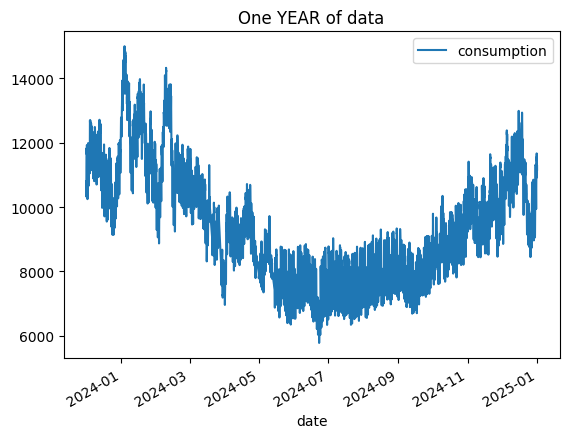

In [8]:
consumption_data.plot(title="One YEAR of data")

2. higher consumption on working days, lower consumption on weekends

<Axes: title={'center': 'One WEEK of data'}, xlabel='date'>

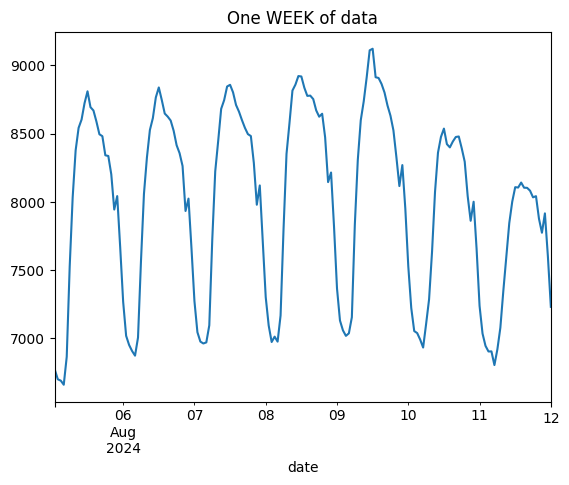

In [9]:
consumption_data["consumption"][5712 : (5712 + 168)].plot(title="One WEEK of data")

3. lower electricity consumption at night and higher consumption during the day

<Axes: title={'center': 'One DAY of data'}, xlabel='date'>

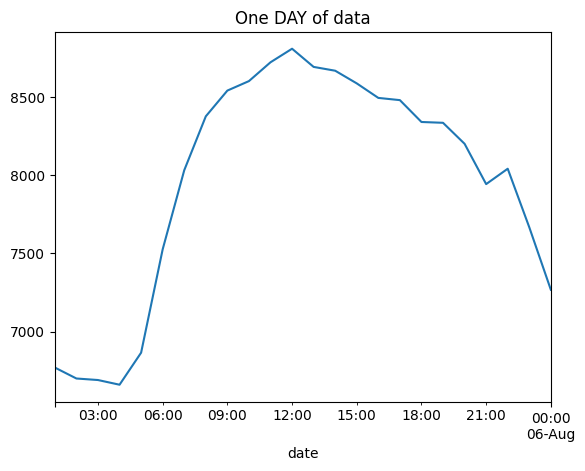

In [10]:
consumption_data["consumption"][5712 : (5712 + 24)].plot(title="One DAY of data")

However, let me note that Finnish electricity consumption apparently exhibits additional patterns.

Finally, let me prepare the data in a specific format for the model to load the data properly.

In [11]:
model_data = consumption_data.copy()
model_data = model_data.reset_index()
model_data["unique_id"] = 1
model_data = model_data.rename(columns={"date": "ds"})

## Forecasting scheme

The model will be used to forecast up to 24 hours ahead every day, starting at midnight. In other words, suppose the first day we want to forecast is Jan 1st 2024. Without knowing any of the future values, the model will output the following sequence of 24 values (in principle):

```
Date                 Forecasted load
00:00 Jan 1st 2024           <value>
01:00 Jan 1st 2024           <value>
02:00 Jan 1st 2024           <value>
...                              ...
23:00 Jan 1st 2024           <value>
```

After that, we move 24 hours into the future and generate a forecast for every hour of Jan 2nd 2024, and so on. This means that the actual process of forecasting will be repeated 366 times on the 2024 data (leap year). Note that this process is called pseudo-out-of-sample forecasting.

In [12]:
only_ymd_no_hour = model_data["ds"].dt.strftime("%Y-%m-%d")
# Return to 23:00 each additional day as it will be the last known datapoint for our forecast
end_hours = model_data.groupby(only_ymd_no_hour).tail(1)["ds"]
end_hours = end_hours[
    end_hours > (Params.forecast_start - timedelta(days=1))
].reset_index(drop=True)
start_hours = end_hours - timedelta(weeks=4)

start_end_hours = pd.DataFrame({"start": start_hours, "end": end_hours})

The `start_end_hours` dataframe of dates will be used to subset the `model_data` dataframe and consequently feed the model with roughly a month of data, as it requires at least some context (much like autoregressive models do).

In [13]:
print(start_end_hours.tail())

                        start                       end
352 2024-11-29 23:00:00+02:00 2024-12-27 23:00:00+02:00
353 2024-11-30 23:00:00+02:00 2024-12-28 23:00:00+02:00
354 2024-12-01 23:00:00+02:00 2024-12-29 23:00:00+02:00
355 2024-12-02 23:00:00+02:00 2024-12-30 23:00:00+02:00
356 2024-12-03 23:00:00+02:00 2024-12-31 23:00:00+02:00


Let me also prepare a dictionary to save the predictions for each predicted day.

In [14]:
forecasts = {
    f"{add_hour_convert(row['end'])}": np.nan for _, row in start_end_hours.iterrows()
}

## Forecasting

Now, I simply load the pre-trained model from HuggingFace, define the length of the forecast horizon, and let all other hyperparameters use [default values](https://github.com/google-research/timesfm/blob/ded73ed55f0a4a844689ad750b618d24b63de007/src/timesfm/timesfm_base.py#L133).

In [ ]:
model_params = timesfm.TimesFmHparams(
    backend="gpu",
    # 24 hours ahead
    horizon_len=Params.horizon,
)
hf_checkpoint = timesfm.TimesFmCheckpoint(
    huggingface_repo_id="google/timesfm-1.0-200m-pytorch"
)
model = timesfm.TimesFm(hparams=model_params, checkpoint=hf_checkpoint)

I then iterate over the dataframe of dates, subsetting the input data accordingly. The resulting dataframe from the `.forecast_on_df()` method is saved into the `forecasts` dictionary for convenient retrieval later. Note that the codeblock below takes a while to finish (~30 mins on my hardware).

In [16]:
for _, row in start_end_hours.iterrows():
    # Used for finding the key in the `forecasts` dictionary
    day_key = add_hour_convert(row["end"])
    # Subset `model_data` such that it's cut off one hour before midnight
    model_data_sub = model_data[
        (model_data["ds"] > row["start"]) & (model_data["ds"] <= row["end"])
    ]
    fcst = model.forecast_on_df(
        inputs=model_data_sub, freq="h", value_name="consumption", num_jobs=-1
    )
    # Save results and print progress
    forecasts[day_key] = fcst
    clear_output(wait=True)
    print("Prediction for", day_key, "generated.")

Prediction for 2025-01-01 generated.


Concatenate all the forecasts into a single dataframe.

In [17]:
out_df = reduce(lambda first, second: pd.concat([first, second]), forecasts.values())
# For simplicity, drop the duplicate row for daylight savings time
out_df = out_df.drop_duplicates(["ds"])

In [18]:
# Further drop 1 extra hour due to daylight savings time
# and the final prediction for the first day of 2025
result_df = pd.merge(left=out_df, right=model_data, on=["ds"], how="inner")
result_df = result_df.set_index("ds", drop=True)
result_df.head()

,unique_id_x,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9,consumption,unique_id_y
ds,,,,,,,,,,,,,
2024-01-01 00:00:00+02:00,1,12542.196289,12372.178711,12438.817383,12475.663086,12511.802734,12542.196289,12582.920898,12621.324219,12667.264648,12754.915039,12598.00,1
2024-01-01 01:00:00+02:00,1,12370.811523,12083.333984,12189.000977,12265.660156,12302.232422,12370.811523,12420.344727,12481.425781,12558.488281,12708.275391,12441.00,1
2024-01-01 02:00:00+02:00,1,12191.220703,11851.639648,11958.962891,12059.300781,12122.700195,12191.220703,12262.336914,12343.323242,12436.316406,12632.057617,12326.25,1
2024-01-01 03:00:00+02:00,1,12085.376953,11690.774414,11830.809570,11912.116211,11991.757812,12085.376953,12150.291016,12239.845703,12358.859375,12548.984375,12185.75,1
2024-01-01 04:00:00+02:00,1,12079.878906,11667.624023,11811.964844,11918.957031,12001.018555,12079.878906,12178.804688,12288.373047,12403.607422,12613.416992,12192.50,1


## Results

Let me use four error metrics: mean absolute percentage error (MAPE), root mean square error (RMSE), R-squared, and mean bias error (MBE). The first two metrics quantify the deviations from reality, while the other two metrics tell us something about the shape and level of the forecasts, respectively.

To reiterate, these forecasts were produced up to 24 hours ahead. This means that without any knowledge of the future values, the model generated 24 point forecasts into the future every day starting at midnight.

In [19]:
print(
    "Total MAPE:",
    np.round(
        mean_absolute_percentage_error(result_df[["timesfm"]], result_df[["consumption"]]),
        5,
    ),
)
print(
    "Total RMSE:",
    np.round(
        root_mean_squared_error(result_df[["timesfm"]], result_df[["consumption"]]), 
        5
    ),
)
print(
    "Total R-squared:",
    np.round(
        r2_score(result_df[["timesfm"]], result_df[["consumption"]]), 
        5
    ),
)
print(
    "Total MBE:",
    np.round(
        mbe(result_df[["timesfm"]], result_df[["consumption"]]), 
        5
    ),
)

Total MAPE: 0.02659
Total RMSE: 356.89071
Total R-squared: 0.95817
Total MBE: 18.25352


The `timesfm` package also provides quantile predictions (experimental feature) so let me take a look if any of these produce lower error.

In [20]:
columns = [f"timesfm-q-0.{i}" for i in np.arange(1, 10)]
for col in columns:
    print(
        f"Total MAPE (column {col}):",
        np.round(
            mean_absolute_percentage_error(result_df[[f"{col}"]], result_df[["consumption"]]),
            5,
        ),
    )
    print(
        f"Total RMSE (column {col})",
        np.round(
            root_mean_squared_error(result_df[[f"{col}"]], result_df[["consumption"]]),
            5,
        ),
    )
    print("-" * 45)

Total MAPE (column timesfm-q-0.1): 0.04381
Total RMSE (column timesfm-q-0.1) 528.25478
---------------------------------------------
Total MAPE (column timesfm-q-0.2): 0.03359
Total RMSE (column timesfm-q-0.2) 426.90602
---------------------------------------------
Total MAPE (column timesfm-q-0.3): 0.02904
Total RMSE (column timesfm-q-0.3) 378.42227
---------------------------------------------
Total MAPE (column timesfm-q-0.4): 0.02704
Total RMSE (column timesfm-q-0.4) 358.0808
---------------------------------------------
Total MAPE (column timesfm-q-0.5): 0.02659
Total RMSE (column timesfm-q-0.5) 356.89071
---------------------------------------------
Total MAPE (column timesfm-q-0.6): 0.02744
Total RMSE (column timesfm-q-0.6) 373.16367
---------------------------------------------
Total MAPE (column timesfm-q-0.7): 0.02974
Total RMSE (column timesfm-q-0.7) 408.19435
---------------------------------------------
Total MAPE (column timesfm-q-0.8): 0.03414
Total RMSE (column timesfm-

The median prediction appears to be the most accurate.

### Plots

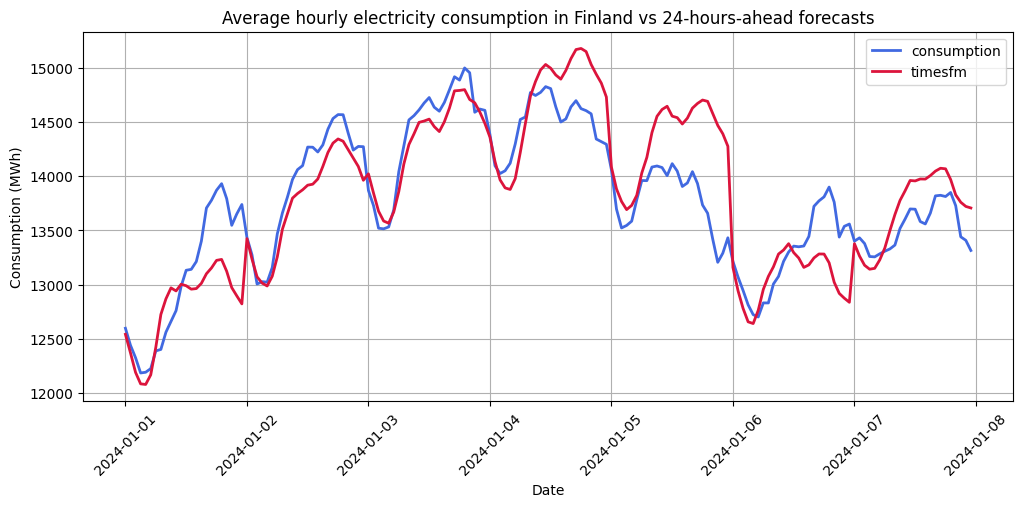

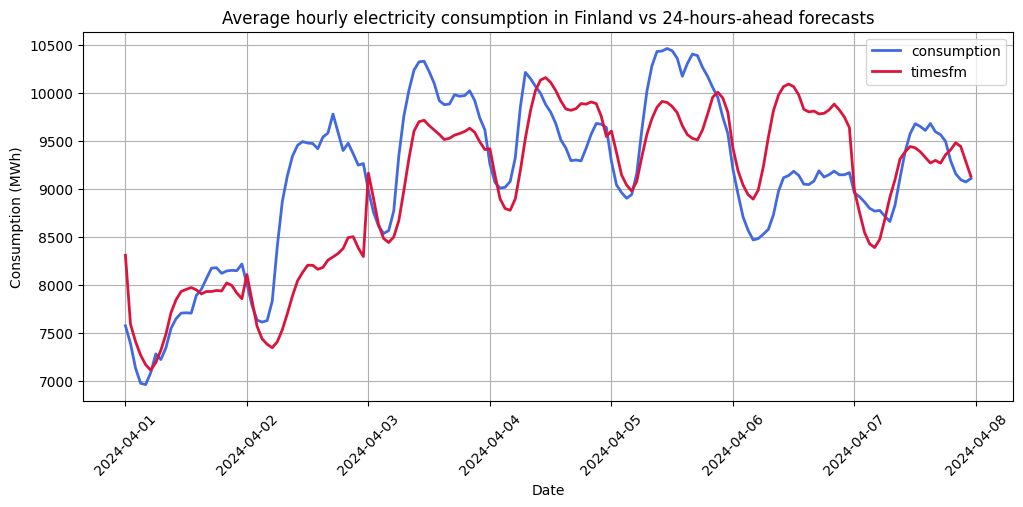

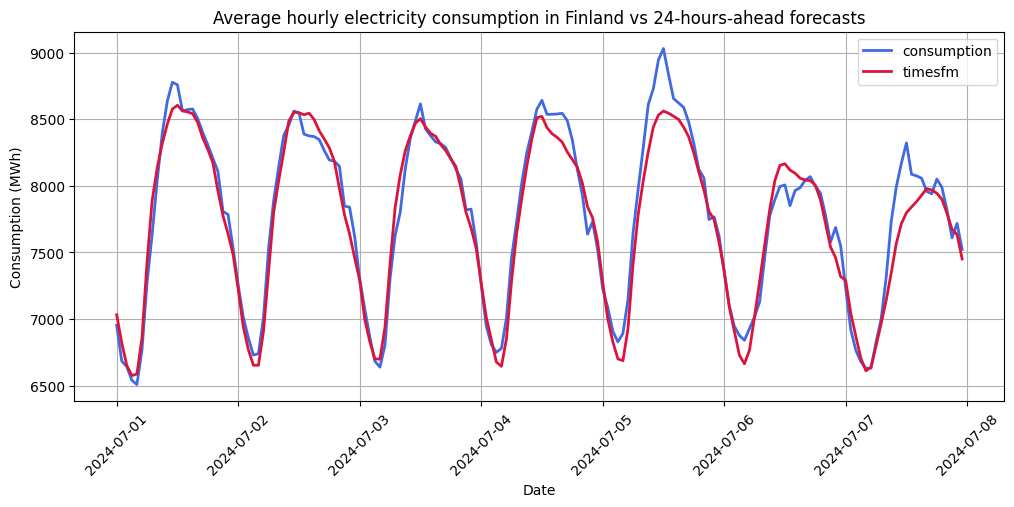

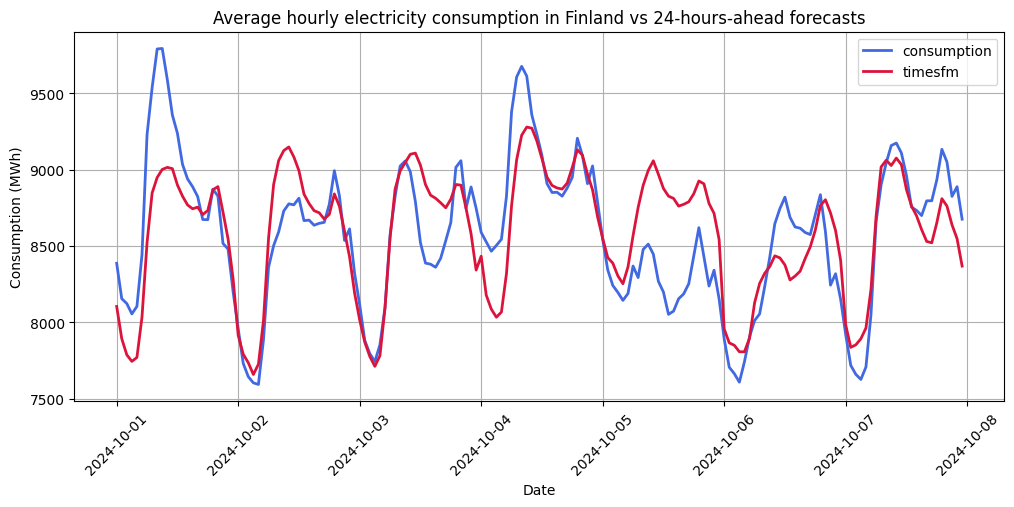

In [21]:
plot_dates = ["2024-01-01", "2024-04-01", "2024-07-01", "2024-10-01"]
# Best timesfm predictions
best_column = "timesfm"

for date in plot_dates:
    int_index = get_int_index(date, result_df)
    generate_lineplot(best_column, int_index, int_index + 168, result_df)

In [22]:
result_monthly = result_df.groupby(pd.Grouper(freq="ME"))[[best_column, "consumption"]]
monthly_mape = result_monthly.apply(
    lambda x: mean_absolute_percentage_error(x[best_column], x["consumption"]) * 100
)
monthly_rmse = result_monthly.apply(
    lambda x: root_mean_squared_error(x[best_column], x["consumption"])
)

monthly_mape.index = monthly_mape.index.strftime("%Y-%m")
monthly_rmse.index = monthly_rmse.index.strftime("%Y-%m")

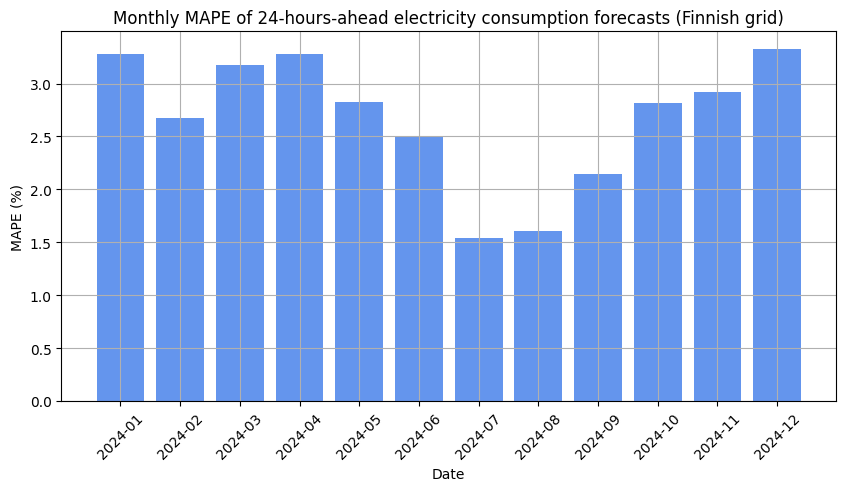

In [23]:
generate_barplot(monthly_mape, "MAPE")

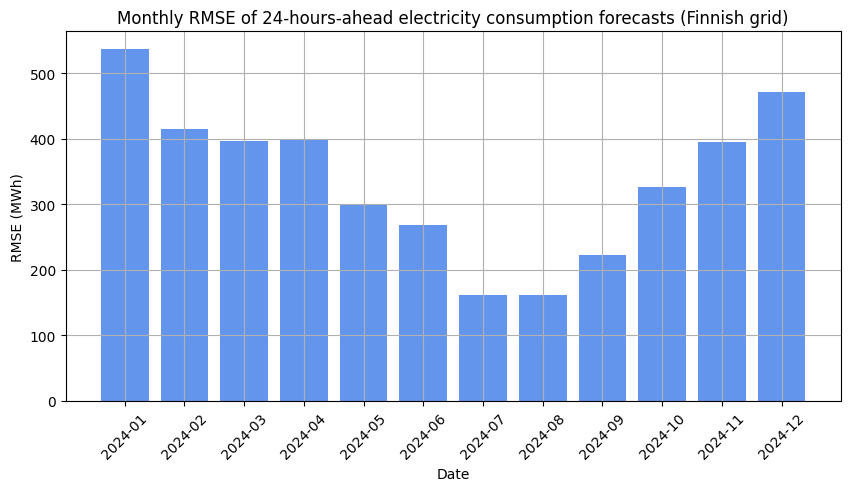

In [24]:
generate_barplot(monthly_rmse, "RMSE")